# Tensorflow recommendation engine
This project aims to build a basic recommendation engine with tensorflow from the ListenBrainz open database (https://console.cloud.google.com/marketplace/product/metabrainz/listenbrainz?project=fun-with-gcp-by-dc&folder=&organizationId=) following the ideas in https://www.johnwittenauer.net/deep-learning-with-keras-recommender-systems/. Specifically, the engine recommends new bands starting from the catalogue of bands listened in the last days/weeks/months.

#### import relevant modules and packages

In [1]:
# modules
import os
import numpy
import pandas
import sklearn.model_selection
import seaborn

# submodules
from tensorflow import keras


# local modules - interface with bigquery
from bigquery_interface import CREDENTIAL_FILE_PATH
from bigquery_interface import build_bigquery_client_with_default_dataset
from bigquery_interface import send_query_to_database

# local modules - preprocessing utilities
from preprocessing_utilities import encode_sequential_labels
from preprocessing_utilities import format_inputs

#### initialize bigquery client and perform handshake queries
The first step to run this project is to initialize a python api that allows me to interface with bigquery. This is done with the functions in build_bigquery_client. For further reference, I also find it convenient to set the google analytics dataset as defeault dataset for successive queries, and to get the database information schema. Getting the information schema allows also to check that the interface API has been properly set up.

In [2]:
# initialize client with default dataset
default_dataset = 'listenbrainz.listenbrainz'    
client, config_object_default_dataset = build_bigquery_client_with_default_dataset(default_dataset)   

# run query to get processed information about the dataset schema
schema_query_path = os.path.join('query_folder', 'schema_query.sql')
dataset_schema = send_query_to_database(client, 
                                        config_object_default_dataset,
                                        schema_query_path)

# print dataset schema
dataset_schema

,filed_name,tables_with_field
0,listened_at,1
1,user_name,1
2,artist_msid,1
3,artist_name,1
4,artist_mbids,1
5,release_msid,1
6,release_name,1
7,release_mbid,1
8,recording_msid,1
9,track_name,1


This summary tells that the dataset is made by a single table with 11 fields. Time to explore the data, then.

#### Database exploration
First step to explor the data is to fetch a snippet of the data in the dataset to understand what is there

In [3]:
# run query to get snippet of dataset
snippet_query_path = os.path.join('query_folder', 'snippet_query.sql')
snippet = send_query_to_database(client, 
                                 config_object_default_dataset,
                                 snippet_query_path)
snippet

,listened_at,user_name,artist_msid,artist_name,artist_mbids,release_msid,release_name,release_mbid,recording_msid,track_name,recording_mbid,tags
0,2018-06-20 19:29:19+00:00,olea,7bc891b1-694c-42a1-b9e9-7f9e0aa04ad5,dj BC,,a4ac533f-ae1b-4649-a31d-29a2d4196e41,Block Rockin' Boots Part.1,,b313d44f-5c02-4cdf-8721-dc41d8f184a4,Big Bros Don't Cry,,
1,2018-06-20 18:57:54+00:00,Clefspeare13,862e6c89-49c5-44c5-81cf-807356523fbf,Dirty Heads,,6e41faee-a364-44aa-8b3a-cb83b01ac0eb,Any Port in the Storm (Special Edition),,d94bacf7-fb85-4671-9569-d9d8e27a2b40,Stand Tall,,
2,2018-06-14 12:39:29+00:00,Schmias,20d1e877-4869-4d06-9fd1-c6b9fadb5fee,Populous,,97631443-7f2f-42d3-aeac-b895f40916c3,Queue For Love,,fe76afbe-b608-473e-8404-17e4d9b97fc7,Pawn Shop Close,,
3,2018-06-20 19:42:48+00:00,paterak,59812ffc-6782-4427-878b-1116ff5c769c,Tool,,3eb8e178-2801-4841-8577-42aef7aa7fb9,Undertow,,e277b8c0-d5a3-4389-9c97-24fbc44b903e,4 Degrees,,
4,2018-06-20 19:53:12+00:00,dannyfritz,a4700c01-74c8-4b4c-97ae-10691ab58c2b,Motion City Soundtrack,,57691480-11c9-4777-a41d-9fd1cd205c3e,Commit This To Memory,,52eaaa09-86f2-42de-9af1-e211af13fd0f,Time Turned Fragile,,
5,2018-06-20 20:02:02+00:00,paterak,59812ffc-6782-4427-878b-1116ff5c769c,Tool,,3babe71e-685d-4b43-a8ef-84029c8d63e5,Ænima,,c0b80ce9-08f2-4c61-b264-9553655434e7,Eulogy,,
6,2018-06-18 10:15:25+00:00,Schmias,18002bf9-9e1e-43d1-bf82-c401555b51a5,Bulimic Orgy & Mile,,8a4fb538-f5ed-4cd3-9941-197b9740c16e,Dairy Plant LP,,76fed746-41ec-4a84-9530-56ce56fb4b79,Dairy Plant,,
7,2018-06-20 17:15:08+00:00,AustinHogan777,a9baf21f-252d-40a8-9557-b2658eb7fab0,Phaeleh,,062c1ac3-cc5b-4316-b915-e8c3e48125d2,Afterglow (Akira Kiteshi Remix) / Low,,d7366a7f-c959-4689-9d3b-bc4272c82bfc,Low,,
8,2018-06-20 19:52:34+00:00,lapseg,9e6a8399-a625-4151-9bba-3994b033957e,Black Sabbath,,fc1b1d07-8286-47c0-a6e5-123cf0b88411,Paranoid (2009 Remastered Version),,4760052c-eaf3-4145-9038-d7f0bde6a1d0,War Pigs (2009 Remastered Version),,
9,2018-06-20 19:37:26+00:00,paterak,59812ffc-6782-4427-878b-1116ff5c769c,Tool,,3eb8e178-2801-4841-8577-42aef7aa7fb9,Undertow,,aacb6fb6-9680-451a-bf53-81b3c4ba7b49,Undertow,,


The snippet shows that I need to focus only on a subset of data to build the engine that I am interested into. Specifically, listened_at, user_name, artist_msid and artist_name. Note that in this choice I am factoring that 
1. artist_mbids are is not a mandatory field of the dataset while artist_msid is. This information comes from the google bigquery documentation of the dataset.
2. tags contains information about genere, but also random comments like "you,just,got,semi,rick,rolled". I will ignore the column for now, but it might be useful in further developments.

Another important info to know is the amount of data I am dealing with. Let's query it

In [4]:
# run query to get database size
database_size_query_path = os.path.join('query_folder', 'database_size_query.sql')
database_size_values     = send_query_to_database(client, 
                                                  config_object_default_dataset,
                                                  database_size_query_path)
database_size_values

,total_entries,total_users,total_artists,first_entry,last_entry
0,146914257,2684,1098454,1970-01-01 00:00:00+00:00,2018-07-24 16:57:19+00:00


Which indicates a huge amounts of total entries, as well a very large number or artists in the database, and a significant number of active users. I can't really think to deal with that, so I will need to subset the data.

A practical way, is to consider recommendations based on the list of artists listened in the last 30 days. The last entry available is on 2018, so I will consider the last 30 days before that date as my working dataset. This limits the amount of data I will work with by a lot. 

In addition, I will directly import from the database the count of times that a user listened to a ginen artist. This will allow to get an implicit rating of an artist for each user.

In [5]:
# import local dataset of music records if in local folder, or fetch it from bigquery
if os.path.exists('local_music_dataset.csv'):
    music_habits_dataset = pandas.read_csv('local_music_dataset.csv')
else:
    fetch_data_of_interest_query_path = os.path.join('query_folder', 'fetch_data_of_interest_query.sql')
    music_habits_dataset              = send_query_to_database(client, 
                                                               config_object_default_dataset,
                                                               fetch_data_of_interest_query_path)
    music_habits_dataset.to_csv('local_music_dataset.csv', index = False)

# show first entries of dataset                                  
music_habits_dataset.head(20)

,user_name,artist_name,artist_msid,number_of_listens
0,-andor-,18+,bd3102b1-064e-4705-bedf-49c5703fc4a7,1
1,-andor-,A. G. Cook,876afd58-c783-45a1-84ac-fd7b59e8bee4,2
2,-andor-,A.G. Cook,96724c6e-299f-4ea0-afb5-ffc1fd444080,1
3,-andor-,Acid Washed,5f10d766-5ca1-4579-a769-2b7ed13a1f30,1
4,-andor-,Arca,cc1ae333-b348-4f43-8d33-40bdd184c62e,4
5,-andor-,Azealia Banks,08603946-8891-45e8-8110-21050dec3fbb,1
6,-andor-,Babeo Baggins,ce04ed26-ca9e-4a61-99cf-8945b55d9919,1
7,-andor-,Black Devil Disco Club,a227ed5c-80d7-4910-9433-c6c0ee067471,1
8,-andor-,BloodPop,1fabd40e-299a-4726-b60e-1de9ae203fa7,1
9,-andor-,Bobmo,fd9d309e-60b3-43e9-971d-156886d769ed,2


#### Exploratory analysis
I will go a bit quick 'n dirty with exploratory analysis because the categorical variables in the dataset have a huge number of possible values, and because the distribution of the numerical variable alone is of very little power if not marginalized by users or artist.

Anyway, let's go with the standard steps. First, rough analysis of the dataset composition.

In [6]:
# data types
music_habits_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77009 entries, 0 to 77008
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_name          77009 non-null  object
 1   artist_name        77009 non-null  object
 2   artist_msid        77009 non-null  object
 3   number_of_listens  77009 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.4+ MB


In [7]:
# numerical variables - quantiles
music_habits_dataset.describe()

,number_of_listens
count,77009.000000
mean,4.013427
std,13.633679
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,1558.000000


What? Someone listens to the same author 1500 times? It's definitely possible, although it has some potential to mess up the predictive model. Let me check if this is an anomaly or not.

In [8]:
# inspect quantiles
music_habits_dataset.quantile(q = [0.9, 0.95, 0.99, 0.999, 0.9999])

,number_of_listens
0.9000,8.0000
0.9500,14.0000
0.9900,43.0000
0.9990,160.9920
0.9999,502.2992


Unfortunately, such values are not anomalous: about 1% of the dataset is made by groups that have been listened to more than 43 times, and 0,01% more than 500 times. 

The simplest solution to avoid that these extreme data dominates my analysis is to log-scale of the number of listens. This should shrink the distribution of values to something comparable for both entries with small number of listens and large numbers of them.


In [9]:
# add log of number of listens
music_habits_dataset['log_number_of_listens'] = numpy.log10(music_habits_dataset['number_of_listens'])

# inspect data again
music_habits_dataset.describe()

,number_of_listens,log_number_of_listens
count,77009.000000,77009.000000
mean,4.013427,0.283231
std,13.633679,0.407362
min,1.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,3.000000,0.477121
max,1558.000000,3.192567


<AxesSubplot:xlabel='log_number_of_listens', ylabel='Count'>

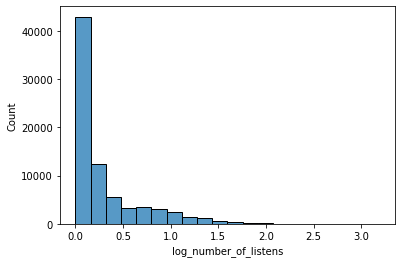

In [10]:
# numerical variables - histogram of logarithme of number of listens
seaborn.histplot(x = 'log_number_of_listens', data = music_habits_dataset, bins = 20)

log_nummber_of_listens has a far smaller spread than number_of_listens. Extreme values still play a role in determining the distributions, but they should not dominate what happens for artists/users with small numbers of listens.

Now, other things that are worth knowing, is how total number of listens distributes among users, and the distribution of how many artists a user listens to. 

       number_of_listens  log_number_of_listens
count         845.000000             845.000000
mean          365.763314               2.151350
std           493.779066               0.730548
min             1.000000               0.000000
25%            59.000000               1.770852
50%           187.000000               2.271842
75%           470.000000               2.672098
max          4671.000000               3.669410


<AxesSubplot:xlabel='log_number_of_listens', ylabel='Count'>

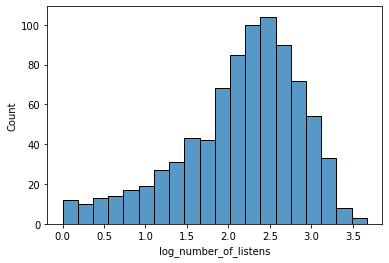

In [11]:
# distribution of number of listens among users
temp = music_habits_dataset.drop(columns = 'log_number_of_listens').groupby('user_name').sum()
temp['log_number_of_listens'] = numpy.log10(temp['number_of_listens'])

print(temp.describe())
seaborn.histplot(x = 'log_number_of_listens', data = temp)

       number_of_listens  log_number_of_listens
count         845.000000             845.000000
mean          365.763314               2.151350
std           493.779066               0.730548
min             1.000000               0.000000
25%            59.000000               1.770852
50%           187.000000               2.271842
75%           470.000000               2.672098
max          4671.000000               3.669410


<AxesSubplot:xlabel='log_number_of_listens', ylabel='Count'>

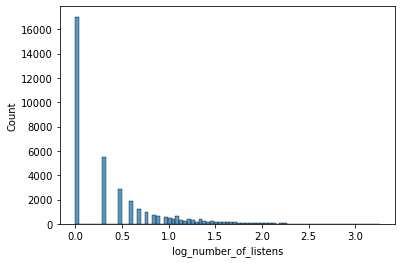

In [12]:
# distribution of number of listens among artists
temp2 = music_habits_dataset.drop(columns = 'log_number_of_listens').groupby('artist_msid').sum()
temp2['log_number_of_listens'] = numpy.log10(temp2['number_of_listens'])

print(temp.describe())
seaborn.histplot(x = 'log_number_of_listens', data = temp2)

Overall, this indicates that 
1. a fair share of users tend to have some hundredth of listens in the dataset. 
2. 25% of the artists have less than 60 total listens in the whole database. 

The data then have the potential to mess up suggestions for such artists because they have a very limited number of entries that the matrix factorization has to optimize. The log-scale of the number of listens can compensate for this a bit, but I fear that lesser known groups might be penalized by the model. 

#### Prepare the dataset
Time to prepare the dataset and then feed it to keras. For the moment I will work mostly on how to pass it from the pandas dataframe music_habits_dataset. I will consider how to do that directly from bigquery in future iterations.

As first step, I need to use the encode the categorical variables user_name and artist_msid. I am sure that this step is to ensure proper indicization, but I am also very suspicios that this will be quite a pain to convert into a proper feature_column operation.

In [13]:
# encode user_name and artist_msid using encode_sequential_labels from the preprocessing_utilities local module
user_encoder,   music_habits_dataset = encode_sequential_labels(music_habits_dataset, 'user_name')
artist_encoder, music_habits_dataset = encode_sequential_labels(music_habits_dataset, 'artist_msid')

Now, let's split the database into the common test-validation-train split. I will use 20% of the complete data as a test set, and a 20% of the remaining data as a validation step. In addition, I will format the inputs of this problem in a specific array format because I will use a specific input format to pass these data to keras.

In [14]:
# split the data in train, validation, test subsets
# define split parameters
split_size = 0.2
random_seed = 0

# split data
train_and_validate_dataframe, test_dataframe = sklearn.model_selection.train_test_split(music_habits_dataset, 
                                                                                        test_size = split_size, 
                                                                                        random_state = 0)
train_dataframe, validate_dataframe          = sklearn.model_selection.train_test_split(train_and_validate_dataframe, 
                                                                                        test_size = split_size)

In [15]:
# format data for train set
x_train, y_train = format_inputs(train_dataframe, 
                                 ['encoded_user_name', 'encoded_artist_msid'],
                                 'log_number_of_listens')
# format data for validation set
x_validate, y_validate = format_inputs(validate_dataframe, 
                                       ['encoded_user_name', 'encoded_artist_msid'],
                                       'log_number_of_listens')
# format data for test set
x_test, y_test = format_inputs(test_dataframe, 
                               ['encoded_user_name', 'encoded_artist_msid'],
                               'log_number_of_listens')


#### Building the recommendation engine
Having all the data in shape, it's finally time to build the recommendation engine itself. This step will assume for the moment a fixed and arbitrary number of features. This is just to be sure that I have implemented everything in the proper way. Later on, I will implement hyperparameter tuning to find the optimal number of features.

First step is to build the model itself by a dedicated function

In [16]:
# define global parameters of use
NUMBER_OF_USERS    = music_habits_dataset['encoded_user_name'].nunique()
NUMBER_OF_ARTISTS  = music_habits_dataset['encoded_artist_msid'].nunique()
NUMBER_OF_FEATURES = int(numpy.round(NUMBER_OF_ARTISTS**(0.25))) # naive empirical estimate 

def build_recommendation_engine():    
    # Create input layer for user names
    user_name_input = keras.layers.Input(shape=(1,))
    # Embedd users with the number of features 
    embedded_user_name = keras.layers.Embedding(NUMBER_OF_USERS, 
                                                NUMBER_OF_FEATURES,
                                                embeddings_initializer='he_normal')(user_name_input)
    # reshape embedding layer to correspond to qualitative picture of matrix factorization
    embedded_user_name = keras.layers.Reshape((NUMBER_OF_FEATURES,))(embedded_user_name)
    
    # Create input layer for artist msid
    artist_msid_input = keras.layers.Input(shape=(1,))
    # Embedd users with the number of features 
    embedded_artists_msid = keras.layers.Embedding(NUMBER_OF_ARTISTS, 
                                                   NUMBER_OF_FEATURES,
                                                   embeddings_initializer='he_normal')(artist_msid_input)
    # reshape embedding layer to correspond to qualitative picture of matrix factorization
    embedded_artists_msid = keras.layers.Reshape((NUMBER_OF_FEATURES,))(embedded_artists_msid)

    # compute an approximation of the original values of log_number_of_features
    # using that the two embeddings are the matrix factorization of log_number_of_features
    appriximated_log_number_of_features = keras.layers.Dot(axes=1)([embedded_user_name, embedded_artists_msid])

    # build recommendation engine a keras model
    recommendation_engine = keras.Model(inputs  = [user_name_input, artist_msid_input], 
                                        outputs = appriximated_log_number_of_features)
    recommendation_engine.compile(loss = 'mean_squared_error', optimizer = 'adam')

    return recommendation_engine

# run function to build engine
recommendation_engine = build_recommendation_engine()
# visual summary of the model
recommendation_engine.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 14)        11830       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 14)        524440      input_2[0][0]                    
______________________________________________________________________________________________

With the recommendation engine model at hand, we can now train it and evaluate its performances.

In [ ]:
recommendation_engine.fit(x = x_train, 
                          y = y_train, 
                          batch_size = 64, 
                          epochs = 5,
                          verbose = 1, 
                          validation_data = (x_validate, y_validate))

Train on 49285 samples, validate on 12322 samples
Epoch 1/5
49285/49285 [==============================] - 16s 328us/sample - loss: 0.2449 - val_loss: 0.2428
Epoch 2/5
49285/49285 [==============================] - 16s 322us/sample - loss: 0.2262 - val_loss: 0.2291
Epoch 3/5
49285/49285 [==============================] - 15s 312us/sample - loss: 0.1708 - val_loss: 0.2152
Epoch 4/5
49285/49285 [==============================] - 15s 313us/sample - loss: 0.1145 - val_loss: 0.2104
Epoch 5/5
36224/49285 [=====================>........] - ETA: 4s - loss: 0.0775